11.8


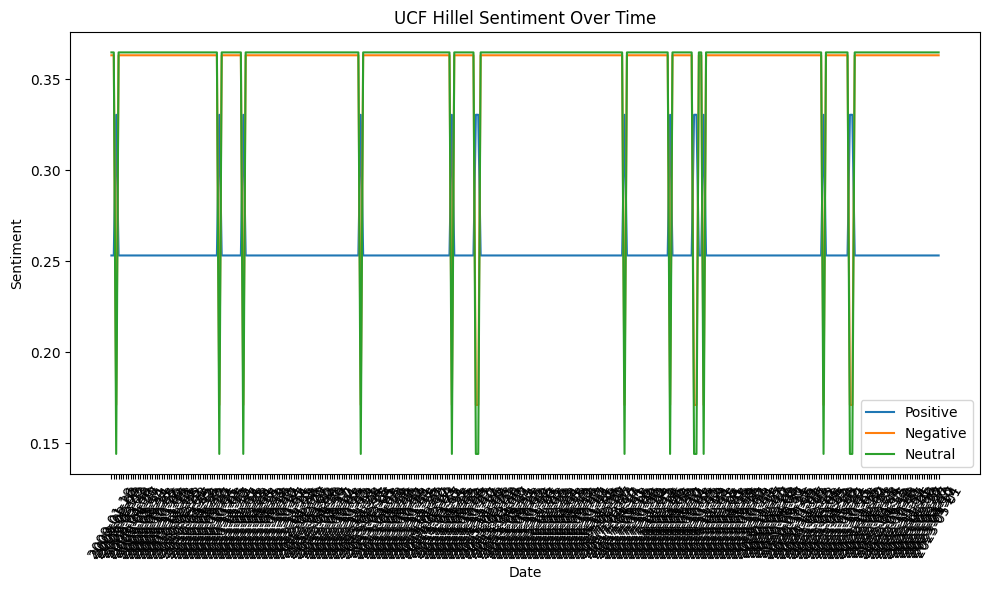

In [6]:
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt

STRING = 'Hillel'
CSV_NAME = 'CMU_hypothesis_sentiment_results'
DF_PATH = 'CMU_Hillel.csv'


print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check and set device
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

def compute_sentiment(row):
    text_entry = row['count']
    scores = get_sentiment_pytorch(text_entry, STRING)
    return tuple(scores)  # Return tuple of scores

def get_sentiment_pytorch(text, string):
    premise = str(text)
    labels = ['positive', 'negative', 'neutral']
    hypotheses = [f'This example is {label} towards {string}.' for label in labels]

    # Tokenize all premises and hypotheses
    inputs = tokenizer.batch_encode_plus(
        [(premise, hypothesis) for hypothesis in hypotheses],
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    
    # Run through model pre-trained on MNLI
    logits = nli_model(**inputs.to(device)).logits

    # Calculate probabilities
    entail_contradiction_logits = logits[:, [0, 2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:, 1]

    return prob_label_is_true.tolist()

def plot_sentiment_over_time(df):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data
    ax.plot(df['date'], df['positive'], label='Positive')
    ax.plot(df['date'], df['negative'], label='Negative')
    ax.plot(df['date'], df['neutral'], label='Neutral')

    # Set the title and axis labels
    ax.set_title(f'CMU {STRING} Sentiment Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    
    # Rotate x-axis tick labels for better visibility
    plt.xticks(rotation=60)

    # Add a legend
    ax.legend()

    # Adjust the figure layout
    fig.tight_layout()

    # Save the plot
    plt.savefig('base_sentiment_results.png', bbox_inches='tight')

    # Show the plot
    plt.show()

df = pd.read_csv(DF_PATH)
df[['positive', 'negative', 'neutral']] = df.apply(compute_sentiment, axis=1, result_type='expand')

# Plot sentiment over time
plot_sentiment_over_time(df)

# Save the updated DataFrame to CSV
df[['date', 'positive', 'negative', 'neutral']].to_csv(f'{CSV_NAME}.csv')
df[['school', 'date', 'count', 'positive', 'negative', 'neutral']].to_csv(f'{CSV_NAME}_expanded.csv')